# -------- Data Processing

In [1]:
# Import Data 
import os
from googletrans import Translator
from striprtf.striprtf import rtf_to_text
import pandas as pd

translator = Translator(service_urls=["translate.googleapis.com"])  

# Defining Key Functions

In [2]:
# import_rtf_files

def import_rtf_files(folder_path):
    rtf_files = []
    title_names = []
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.rtf'):
            title_names.append(file_name)
            file_path = os.path.join(folder_path, file_name)
            with open(file_path) as file:
                doc = rtf_to_text(file.read())
                #remove tabs
                doc = doc.replace('\t', '')
                rtf_files.append(doc)
    return title_names, rtf_files

# Import Metadata

In [3]:
meta_df = pd.read_excel(os.path.join(os.getcwd(), "raw_data/Results list for_omgevingswet.xlsx")).drop("Summary", axis=1)
meta_df.index = meta_df.index + 1
meta_df.head()

,Headline,Publication,Date
1,130 km straks geen item meer,"Leidsch Dagblad, BIJLAGE; Blz. 002, 1512 words",2017-10-14
2,14 dingen die je beter niet kunt doen tijdens ...,"NRC, LEVEN; Blz. 8, 837 words",2023-06-13
3,"Achtkarspelen, kom op met die monumentenlijst","Friesch Dagblad, 157 words",2022-01-08
4,Advies: ICT vormt risico bij invoer Omgevingswet,"Friesch Dagblad, 184 words",2022-10-12
5,Alles doorstaan maar geen liefde geoogst,"de Volkskrant, Ten Eerste; Blz. 8, 9, 6 words",2016-09-20


# Import Article Files and Translate

In [4]:
# Test single entry
s_title_texts, dutch_texts = import_rtf_files(os.path.join(os.getcwd(), "raw_data/"))

for dutch_text in dutch_texts:
    split_texts = dutch_text.split("End of Document")
    split_texts.pop()
    print(len(split_texts))

100
100
100
77


In [5]:
# import files
folder_paths = [os.path.join(os.getcwd(), "raw_data/")]

dutch_texts = []
english_texts = []
id_texts = []
id = 1

#assume only single path
for folder_path in folder_paths:

    # for a single path
    s_title_texts, s_dutch_texts = import_rtf_files(folder_path)

    #for each 100 files in a rtf
    for dutch_text in s_dutch_texts:

        # split and give ID
        split_texts = dutch_text.split("End of Document")
        split_texts.pop() # remove last entry

        # translate rtf_texts
        for split_text in split_texts: 
            
            #add ID
            id_texts.append(id)
            id = id + 1

            #translate entry
            english_text = translator.translate(split_text, src='nl', dest='en') 
            english_texts.append(english_text) 

            # add original dutch text
            dutch_texts.append(split_text)

In [6]:
# Test if all files are parsed
# 3 Files in total

print (len(id_texts),len(dutch_texts),len(english_texts))
#print(id_texts[4])
#print(dutch_texts[4])
#print(english_texts[4])

377 377 377


# Compile Corpus with Metadata

In [7]:
# Create df from origin data
text_df = pd.DataFrame({'Dutch': dutch_texts, 'English': english_texts})
text_df.index = id_texts

text_df.head()

,Dutch,English
1,\n\n\n\n\n130 km straks geen item meer\nLeidsc...,"Translated(src=nl, dest=en, text=130 km soon n..."
2,\n\n\n\n\n\n\n14 dingen die je beter niet kunt...,"Translated(src=nl, dest=en, text=14 things not..."
3,"\n\n\n\n\n\n\nAchtkarspelen, kom op met die mo...","Translated(src=nl, dest=en, text=Eight-kart ga..."
4,\n\n\n\n\n\n\nAdvies: ICT vormt risico bij inv...,"Translated(src=nl, dest=en, text=Advice: ICT p..."
5,\n\n\n\n\n\n\nAlles doorstaan maar geen liefde...,"Translated(src=nl, dest=en, text=Endured every..."


In [8]:
merged_df = pd.merge(meta_df, text_df, left_index=True, right_index=True)
merged_df.head()

,Headline,Publication,Date,Dutch,English
1,130 km straks geen item meer,"Leidsch Dagblad, BIJLAGE; Blz. 002, 1512 words",2017-10-14,\n\n\n\n\n130 km straks geen item meer\nLeidsc...,"Translated(src=nl, dest=en, text=130 km soon n..."
2,14 dingen die je beter niet kunt doen tijdens ...,"NRC, LEVEN; Blz. 8, 837 words",2023-06-13,\n\n\n\n\n\n\n14 dingen die je beter niet kunt...,"Translated(src=nl, dest=en, text=14 things not..."
3,"Achtkarspelen, kom op met die monumentenlijst","Friesch Dagblad, 157 words",2022-01-08,"\n\n\n\n\n\n\nAchtkarspelen, kom op met die mo...","Translated(src=nl, dest=en, text=Eight-kart ga..."
4,Advies: ICT vormt risico bij invoer Omgevingswet,"Friesch Dagblad, 184 words",2022-10-12,\n\n\n\n\n\n\nAdvies: ICT vormt risico bij inv...,"Translated(src=nl, dest=en, text=Advice: ICT p..."
5,Alles doorstaan maar geen liefde geoogst,"de Volkskrant, Ten Eerste; Blz. 8, 9, 6 words",2016-09-20,\n\n\n\n\n\n\nAlles doorstaan maar geen liefde...,"Translated(src=nl, dest=en, text=Endured every..."


In [9]:
# Iterate through every row in the DataFrame
for index, row in merged_df.iterrows():
    pub_data = row['Publication'].split(',')
    merged_df.at[index,'Source'] = pub_data[0]
    merged_df.at[index, 'Words'] = pub_data[-1].replace(" words","")

merged_df.head()

,Headline,Publication,Date,Dutch,English,Source,Words
1,130 km straks geen item meer,"Leidsch Dagblad, BIJLAGE; Blz. 002, 1512 words",2017-10-14,\n\n\n\n\n130 km straks geen item meer\nLeidsc...,"Translated(src=nl, dest=en, text=130 km soon n...",Leidsch Dagblad,1512
2,14 dingen die je beter niet kunt doen tijdens ...,"NRC, LEVEN; Blz. 8, 837 words",2023-06-13,\n\n\n\n\n\n\n14 dingen die je beter niet kunt...,"Translated(src=nl, dest=en, text=14 things not...",NRC,837
3,"Achtkarspelen, kom op met die monumentenlijst","Friesch Dagblad, 157 words",2022-01-08,"\n\n\n\n\n\n\nAchtkarspelen, kom op met die mo...","Translated(src=nl, dest=en, text=Eight-kart ga...",Friesch Dagblad,157
4,Advies: ICT vormt risico bij invoer Omgevingswet,"Friesch Dagblad, 184 words",2022-10-12,\n\n\n\n\n\n\nAdvies: ICT vormt risico bij inv...,"Translated(src=nl, dest=en, text=Advice: ICT p...",Friesch Dagblad,184
5,Alles doorstaan maar geen liefde geoogst,"de Volkskrant, Ten Eerste; Blz. 8, 9, 6 words",2016-09-20,\n\n\n\n\n\n\nAlles doorstaan maar geen liefde...,"Translated(src=nl, dest=en, text=Endured every...",de Volkskrant,6


# Filter Corpus for Noise

In [10]:
# Filter Repetitions

filter_df = merged_df.drop_duplicates(subset=['Headline',"Words"])
print("filtered entries: ", len(merged_df) - len(filter_df) )

filtered entries:  0


# Export Full Dataset as CSV

In [11]:
# Write DataFrame to CSV file

dir_path = os.path.dirname(os.path.realpath('__file__'))
file_path = os.path.join(dir_path, "translated_data",'full_dataset.xlsx')
filter_df.to_excel(file_path, index_label= False)

# ------ Analyze Time Slices

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
merged_df = pd.read_excel(os.path.join(os.getcwd(), "translated_data/full_dataset.xlsx"), index_col=0)
merged_df.tail()

,Headline,Publication,Date,Dutch,English,Source,Words
373,"Zo gaat dat dus, de Kamer verkeerd informeren","de Volkskrant, Ten Eerste; Blz. 2, 566 words",2022-08-10,"\n\n\n\n\n\n\nZo gaat dat dus, de Kamer verkee...","Translated(src=nl, dest=en, text=That's how it...",de Volkskrant,566
374,Zorgen over vertraging bij bouwplannen in Teyl...,"Leidsch Dagblad, REGIO; Blz. 4, 459 words",2022-04-07,\n\n\n\n\n\n\nZorgen over vertraging bij bouwp...,"Translated(src=nl, dest=en, text=Concerns abou...",Leidsch Dagblad,459
375,Zo werd ertoch gebouwd naast een vuurwerkopslag,"NRC.NEXT, IN HET NIEUWS; Blz. 6, 1764 words",2020-02-10,\n\n\n\n\n\n\nZo werd ertoch gebouwd naast een...,"Translated(src=nl, dest=en, text=So it was bui...",NRC.NEXT,1764
376,’Gemeente Alphen aan den Rijn is voorloper’,"Leidsch Dagblad, REGIO; Blz. 009, 605 words",2018-10-24,\n\n\n\n\n\n\n’Gemeente Alphen aan den Rijn is...,"Translated(src=nl, dest=en, text='Municipality...",Leidsch Dagblad,605
377,’Wethouders extra logisch’,"Leidsch Dagblad, BIBU; Blz. 002, 639 words",2018-06-21,\n\n\n\n\n\n\n’Wethouders extra logisch’\nLeid...,"Translated(src=nl, dest=en, text='Aldermen ext...",Leidsch Dagblad,639


In [3]:
# Convert the 'Date' column to datetime
merged_df['Date'] = pd.to_datetime(merged_df['Date'])

In [130]:

# Define phase boundaries and counts
phase1_count = merged_df[merged_df['Date'] < pd.Timestamp('2016-06-01')].shape[0]
phase2_count = merged_df[(merged_df['Date'] >= pd.Timestamp('2016-06-01')) & (merged_df['Date'] < pd.Timestamp('2020-01-01'))].shape[0]
phase3_count = merged_df[(merged_df['Date'] >= pd.Timestamp('2020-01-01')) & (merged_df['Date'] < pd.Timestamp('2022-01-01'))].shape[0]
phase4_count = merged_df[merged_df['Date'] >= pd.Timestamp('2022-01-01')].shape[0]

# Create a DataFrame for the table
phase_counts = pd.DataFrame({
    'Phase': ['Phase 1', 'Phase 2', 'Phase 3', 'Phase 4'],
    'Number of Articles': [phase1_count, phase2_count, phase3_count, phase4_count]
})

# Display the table
print(phase_counts)

     Phase  Number of Articles
0  Phase 1                  29
1  Phase 2                  61
2  Phase 3                 113
3  Phase 4                 174


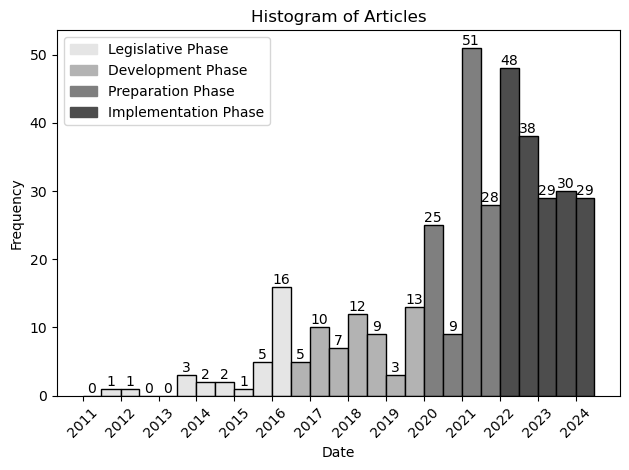

In [131]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import numpy as np

# Assuming merged_df['Date'] contains datetime objects
# Extract years from the datetime objects
merged_df['Year'] = merged_df['Date'].dt.year

# Define the bins for half-year intervals
bins = pd.date_range(start='2011-01-01', end='2024-07-30', freq='6MS')



colors = []
pal = ['#E5E5E5','#B3B3B3','#7F7F7F','#4D4D4D']
for bin_start in bins:
    if pd.Timestamp(bin_start, unit='d') < pd.Timestamp('2016-06-01'):
        colors.append(pal[0])
    elif pd.Timestamp('2016-06-01') <= pd.Timestamp(bin_start, unit='d') < pd.Timestamp('2020-01-01'):
        colors.append(pal[1])
    elif pd.Timestamp('2020-01-01') <= pd.Timestamp(bin_start, unit='d') < pd.Timestamp('2022-01-01'):
        colors.append(pal[2])
    else:
        colors.append(pal[3])

# Plot the histogram with the specified colors
for i in range(len(hist)):
    plt.bar(bins[i], hist[i], width=(bins[i+1] - bins[i]).days, color=colors[i], edgecolor='black', align='edge')

plt.title('Histogram of Articles')
plt.xlabel('Date')
plt.ylabel('Frequency')

# Set x-ticks to be half-yearly
yearly_ticks = pd.date_range(start='2011-01-01', end=max(merged_df['Date']), freq='YS')
plt.xticks(yearly_ticks, yearly_ticks.year, rotation=45)

# Add quantity information on each bar
for i in range(len(hist)):
    plt.text(bins[i] + (bins[i+1] - bins[i])/2, hist[i], str(int(hist[i])), ha='center', va='bottom')

# Create legend
phase1_patch = mpatches.Patch(color=pal[0], label='Legislative Phase')
phase2_patch = mpatches.Patch(color=pal[1], label='Development Phase')
phase3_patch = mpatches.Patch(color=pal[2], label='Preparation Phase')
phase4_patch = mpatches.Patch(color=pal[3], label='Implementation Phase')
plt.legend(handles=[phase1_patch, phase2_patch, phase3_patch, phase4_patch])

plt.tight_layout()
plt.show()

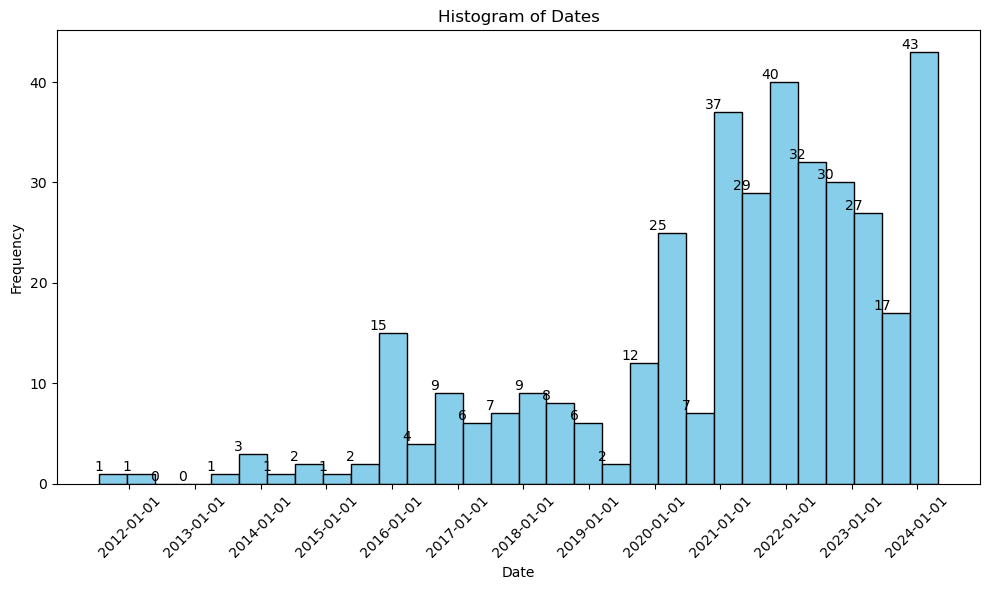

In [5]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming mergeda_df['Date'] contains datetime objects
# Extract years from the datetime objects
merged_df['Year'] = merged_df['Date'].dt.year

plt.figure(figsize=(10, 6))
hist, bins, _ = plt.hist(merged_df['Date'], bins=30, color='skyblue', edgecolor='black')
plt.title('Histogram of Dates')
plt.xlabel('Date')
plt.ylabel('Frequency')

# Set x-ticks to be yearly
plt.xticks(pd.date_range(start=min(merged_df['Date']), end=max(merged_df['Date']), freq='YS'), rotation=45)

# Add quantity information on each bar
for i in range(len(hist)):
    plt.text(bins[i], hist[i], str(int(hist[i])), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [6]:
merged_df[merged_df['Year'] == 2024]

,Headline,Publication,Date,Dutch,English,Source,Words,Year
7,Alle wetten en regels in één digitaal loket om...,"Leidsch Dagblad, BIBU; Blz. 12, 1811 words",2024-01-03,\n\n\n\n\n\n\nAlle wetten en regels in één dig...,"Translated(src=nl, dest=en, text=All laws and ...",Leidsch Dagblad,1811,2024
18,Bestemmingsplannengolf 39,"Leidsch Dagblad, REGIO; Blz. 2, 106 words",2024-01-05,\n\n\n\n\n\n\nBestemmingsplannengolf; 39\nLeid...,"Translated(src=nl, dest=en, text=Zoning wave; ...",Leidsch Dagblad,106,2024
40,Compostbultje dwarsboomt migrantenhotel,"de Volkskrant, Ten Eerste; Blz. 3, 945 words",2024-01-18,\n\n\n\n\n\n\nCompostbultje dwarsboomt migrant...,"Translated(src=nl, dest=en, text=Compost pile ...",de Volkskrant,945,2024
61,De vleermuis heeft bij ons zo zijn eigen woonc...,"de Volkskrant, Ten Eerste; Blz. 16, 501 words",2024-01-09,\n\n\n\n\n\n\nDe vleermuis heeft bij ons zo zi...,"Translated(src=nl, dest=en, text=The bat has i...",de Volkskrant,501,2024
64,Deze veranderingen gelden per 1 januari: frisd...,"de Volkskrant, Ten Eerste; Blz. 4, 921 words",2024-01-02,\n\n\n\n\n\n\nDeze veranderingen gelden per 1 ...,"Translated(src=nl, dest=en, text=These changes...",de Volkskrant,921,2024
72,Een minister voor Digitale Zaken is hoognodig,"NRC, OPINIE; Blz. 18, 902 words",2024-04-18,\n\n\n\n\n\n\nEen minister voor Digitale Zaken...,"Translated(src=nl, dest=en, text=A Minister fo...",NRC,902,2024
79,EU te traag met klimaatmaatregelen',"NRC, WETENSCHAP; Blz. 16, 769 words",2024-03-12,\n\n\n\n\n\n\n'EU te traag met klimaatmaatrege...,"Translated(src=nl, dest=en, text='EU too slow ...",NRC,769,2024
80,Experts stellen strenge eisen aan Tata subsidi...,"Leidsch Dagblad, BIBU; Blz. 2, 1047 words",2024-02-29,\n\n\n\n\n\n\nExperts stellen strenge eisen aa...,"Translated(src=nl, dest=en, text=Experts place...",Leidsch Dagblad,1047,2024
88,Geachte redactie,"de Volkskrant, Zaterdag; Blz. 22, 23, 1337 words",2024-04-26,\n\n\n\n\n\n\nGeachte redactie\nde Volkskrant\...,"Translated(src=nl, dest=en, text=Dear editors\...",de Volkskrant,1337,2024
94,Geen Mac op deze plek: fastfoodverzet breidt z...,"de Volkskrant, Ten Eerste; Blz. 13, 14, 15, 20...",2024-04-02,\n\n\n\n\n\n\nGeen Mac op deze plek: fastfoodv...,"Translated(src=nl, dest=en, text=No Mac in thi...",de Volkskrant,2051,2024


# ------ Export Translated Files as TXT for DNA

In [23]:
for i in range(len(merged_df['Headline'])):
    
    # title name id+ .txt
    id_value = "{:03d}".format(merged_df.index[i])
    newspaper_name = str(merged_df["Source"].iloc[i]).replace(" ", "").replace(".", "")
    date = str(merged_df["Date"].iloc[i].strftime('%Y.%m.%d'))
    
    new_title = f"{id_value}_{newspaper_name}_{date}.txt"

    file_path = os.path.join("translated_data/", new_title)

    with open(file_path, 'w') as file:
        file.write(str(merged_df["English"].iloc[i]))